# Setup

In [1]:
import os
import math
import time
import psutil
import random
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils as utils
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split



if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
set_seed(42)

using cpu


# Data Preprocessing

### MUTAG Dataset

In [2]:
# Load the MUTAG dataset
mutag_data = TUDataset(root='/tmp/MUTAG', name='MUTAG')
print(mutag_data[0])

# Split the dataset into train, validation, and test sets
train_val_data, test_data = train_test_split(mutag_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)

# Create data loaders
mutag_train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
mutag_val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
mutag_test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Get the number of features and classes from the dataset
mutag_num_features = mutag_data.num_features
mutag_num_classes = mutag_data.num_classes
print(f'Num Features = {mutag_num_features}, Num Classes = {mutag_num_classes}')

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Num Features = 7, Num Classes = 2


### EMCI-AD Dataset

### SLIM160 Dataset

### Maturation Dataset

# Models

In [84]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

## GCN Models
class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features*2)
        self.fc = torch.nn.Linear(hidden_features*2, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = F.relu(self.gcn2(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

## GCESN Model
class RidgeLayer(nn.Module):
    def __init__(self, in_features, out_features, alpha=1):
        super(RidgeLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.alpha = alpha

    def forward(self, x):
        return self.linear(x)

    def ridge_regularization(self):
        return self.alpha * torch.sum(self.linear.weight ** 2)

class GCESN_1layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5, ridge_alpha=0.9):
        super(GCESN_1layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.ridge_layer = RidgeLayer(hidden_features, hidden_features, ridge_alpha)
        
        self.fc = nn.Linear(self.hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W))))
        h = self.ridge_layer(h)
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_2layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5, ridge_alpha=0.9):
        super(GCESN_2layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.ridge_layer_1 = RidgeLayer(hidden_features, 2*hidden_features, ridge_alpha)
        self.ridge_layer_2 = RidgeLayer(2*hidden_features, hidden_features, 0.7)
        
        self.fc = nn.Linear(self.hidden_features, num_classes)

    def initialize_weights(self):
        self.Win_1 = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win_1)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.ridge_layer_1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.ridge_layer_2(h)

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


## Decoupled GCESN Model
class decoupledGCESN_1layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=1, ridge_alpha=0.9):
        super(decoupledGCESN_1layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations

        self.gcn1 = GCN(in_features, hidden_features)
        self.ridge_layer = RidgeLayer(hidden_features, hidden_features, ridge_alpha)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW
        
    def forward(self, x, adj, batch):
        n_node, _ = x.shape
        # set_seed(42) 
        state = torch.zeros(n_node, self.hidden_features).to(device)
        h = x

        h = F.relu(self.gcn1(h, adj))
        for _ in range(self.num_iterations):
            state = (1-self.leaky_rate)*state + self.leaky_rate*(torch.relu(torch.mm(h, self.Win) + torch.mm(state, self.W)))
        
        x = self.ridge_layer(state)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class decoupledGCESN_2layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=1, ridge_alpha=0.9):
        super(decoupledGCESN_2layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations

        self.gcn1 = GCN(in_features, hidden_features)
        self.ridge_layer_1 = RidgeLayer(hidden_features, 2*hidden_features, ridge_alpha)
        
        self.gcn2 = GCN(hidden_features, 2*hidden_features)
        # self.ridge_layer_2 = RidgeLayer(2*hidden_features, hidden_features, 0.7)
        self.fc = nn.Linear(2*hidden_features, num_classes)

    def initialize_weights(self):
        self.Win_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_1   = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.Win_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_2   = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2
        
    def forward(self, x, adj, batch):
        n_node, _ = x.shape
        state = torch.zeros(n_node, self.hidden_features).to(device)
        h = x

        h = F.relu(self.gcn1(h, adj))
        for _ in range(self.num_iterations):
            state = (1-self.leaky_rate)*state + self.leaky_rate*(torch.relu(torch.mm(h, self.Win_1) + torch.mm(state, self.W_1)))
        state = self.ridge_layer_1(state)

        h = F.relu(self.gcn2(h, adj))
        for _ in range(self.num_iterations):
            state = (1-self.leaky_rate)*state + self.leaky_rate*(torch.relu(torch.mm(h, self.Win_2) + torch.mm(state, self.W_2)))
        # h = self.ridge_layer_2(state)
        
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Trainings & Evaluations

In [5]:
## Single Functions
def single_train(model, loader, val_loader, lr=0.001, num_epochs=100, patience=5, step_size=50, gamma=0.1, save_path='models/gcn_x.pth', binary_classification=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    epochs_no_improve = 0

    model.to(device)

    # Get the process object for the current process
    process = psutil.Process()

    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        # Measure CPU and GPU usage before the epoch
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0

        for data in loader:
            x, edge_index, batch, y = data.x.to(device), data.edge_index.to(device), data.batch.to(device), data.y.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)

            optimizer.zero_grad()
            output = model(x, adj_matrix, batch)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.num_graphs
        
        scheduler.step()  # Step the learning rate scheduler

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        
        # Measure CPU and GPU usage after the epoch
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        # Calculate average CPU and GPU usage during the epoch
        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        training_loss.append(epoch_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                x, edge_index, batch, y = val_data.x.to(device), val_data.edge_index.to(device), val_data.batch.to(device), val_data.y.to(device)
                adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
                val_output = model(x, adj_matrix, batch)
                val_loss += criterion(val_output, y).item() * val_data.num_graphs

        validation_loss.append(val_loss)

        # Early stopping logic considering both training and validation loss
        if val_loss < best_val_loss or epoch_loss < best_train_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
            epochs_no_improve = 0
            total_epoch = epoch + 1
            torch.save(model.state_dict(), save_path)  # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                total_epoch = epoch + 1
                break

        print(f'Epoch {epoch + 1}, Train Loss: {epoch_loss}, Val Loss: {val_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage_percent[-1]:.2f}%, Memory: {memory_usage[-1]:.2f}GB, GPU: {gpu_usage[-1]:.2f}GB, GPU Util: {gpu_usage_percent[-1]:.2f}%')

    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    model.load_state_dict(torch.load(save_path))
    print(f'Model saved to {save_path}')

    avg_epoch_time = np.mean(epoch_time)
    avg_cpu_usage_percent = np.mean(cpu_usage_percent)
    avg_memory_usage = np.mean(memory_usage)
    avg_gpu_usage = np.mean(gpu_usage)
    avg_gpu_usage_percent = np.mean(gpu_usage_percent)
    total_training_time = np.sum(epoch_time)
    max_cpu_usage_percent = np.max(cpu_usage_percent)
    max_memory_usage = np.max(memory_usage)
    max_gpu_usage = np.max(gpu_usage)
    max_gpu_usage_percent = np.max(gpu_usage_percent)

    print(f'Average Time per Epoch: {avg_epoch_time:.2f}s')
    print(f'Average CPU Usage: {avg_cpu_usage_percent:.2f}%')
    print(f'Average Memory Usage: {avg_memory_usage:.2f}GB')
    print(f'Average GPU Usage: {avg_gpu_usage:.2f}GB')
    print(f'Average GPU Utilization: {avg_gpu_usage_percent:.2f}%')

    print(f'\nTotal Training Time: {total_training_time:.2f}s')
    print(f'Max CPU Usage: {max_cpu_usage_percent:.2f}%')
    print(f'Max Memory Usage: {max_memory_usage:.2f}GB')
    print(f'Max GPU Usage: {max_gpu_usage:.2f}GB')
    print(f'Max GPU Utilization: {max_gpu_usage_percent:.2f}%')

    return

def binary_evaluation(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    return accuracy, sensitivity, specificity

def multiclass_evaluation(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix:\n{cm}')

    # Calculate metrics
    accuracy = np.trace(cm) / np.sum(cm)
    sensitivity = np.zeros(cm.shape[0])
    specificity = np.zeros(cm.shape[0])
    
    for i in range(cm.shape[0]):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FN + FP)

        sensitivity[i] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else 0

    avg_sensitivity = np.mean(sensitivity)
    avg_specificity = np.mean(specificity)

    return accuracy, avg_sensitivity, avg_specificity
    
def single_test(model, loader, binary_classification=True):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
            output = model(x, adj_matrix, batch)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())

    if binary_classification:
        accuracy, sensitivity, specificity = binary_evaluation(y_true, y_pred)
    else:
        accuracy, sensitivity, specificity = multiclass_evaluation(y_true, y_pred)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Average Sensitivity (Recall): {sensitivity:.4f}')
    print(f'Average Specificity: {specificity:.4f}')
    return 


#### Multiple

In [56]:
## Multiple Runs
def multi_train(model, loader, val_loader, lr=0.001, num_epochs=100, patience=5, step_size=50, gamma=0.1, binary_classification=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    epochs_no_improve = 0

    model.to(device)

    # Get the process object for the current process
    process = psutil.Process()

    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        # Measure CPU and GPU usage before the epoch
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0

        for data in loader:
            x, edge_index, batch, y = data.x.to(device), data.edge_index.to(device), data.batch.to(device), data.y.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)

            optimizer.zero_grad()
            output = model(x, adj_matrix, batch)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.num_graphs
        
        scheduler.step()  # Step the learning rate scheduler

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        
        # Measure CPU and GPU usage after the epoch
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        # Calculate average CPU and GPU usage during the epoch
        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        training_loss.append(epoch_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                x, edge_index, batch, y = val_data.x.to(device), val_data.edge_index.to(device), val_data.batch.to(device), val_data.y.to(device)
                adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
                val_output = model(x, adj_matrix, batch)
                val_loss += criterion(val_output, y).item() * val_data.num_graphs

        validation_loss.append(val_loss)

        # Early stopping logic considering both training and validation loss
        if val_loss < best_val_loss or epoch_loss < best_train_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
            epochs_no_improve = 0
            total_epoch = epoch + 1
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                total_epoch = epoch + 1
                break

    total_training_time = np.sum(epoch_time)
    avg_epoch_time = np.mean(epoch_time)

    avg_cpu_usage_percent = np.mean(cpu_usage_percent)
    avg_gpu_usage = np.mean(gpu_usage)
    avg_memory_usage = np.mean(memory_usage)

    max_cpu_usage_percent = np.max(cpu_usage_percent)
    max_gpu_usage = np.max(gpu_usage)
    max_memory_usage = np.max(memory_usage)

    return training_loss[-1], total_epoch, total_training_time, avg_epoch_time, avg_cpu_usage_percent, avg_gpu_usage, avg_memory_usage, max_cpu_usage_percent, max_gpu_usage, max_memory_usage 
   
def multi_test(model, loader, binary_classification=True):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
            output = model(x, adj_matrix, batch)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())

    if binary_classification:
        accuracy, sensitivity, specificity = binary_evaluation(y_true, y_pred)
    else:
        accuracy, sensitivity, specificity = multiclass_evaluation(y_true, y_pred)
    
    return accuracy, sensitivity, specificity

def multi_train_test(model, train_loader, val_loader, test_loader, num_runs=10, 
                    lr=0.001, num_epochs=100, patience=5, step_size=50, gamma=0.1, 
                    binary_classification=True):

    all_accuracies = []
    all_sensitivities = []
    all_specificities = []

    all_training_times = []
    all_epoch_time = []
    all_epoch = []

    all_avg_cpu_usages = []
    all_avg_gpu_usages = []
    all_avg_memory_usages = []

    all_max_cpu_usages = []
    all_max_gpu_usages = []
    all_max_memory_usages = []
    

    for run in range(num_runs):
        set_seed(run)
        model.initialize_weights()
        loss, total_epoch, training_time, epoch_time, avg_cpu, avg_gpu, avg_memory, max_cpu, max_gpu, max_memory = multi_train(model, train_loader, val_loader, lr=0.01, num_epochs=num_epochs)

        accuracy, sensitivity, specificity = multi_test(model, test_loader, binary_classification)

        # Store results
        all_accuracies.append(accuracy)
        all_sensitivities.append(sensitivity)
        all_specificities.append(specificity)

        all_training_times.append(training_time)
        all_epoch_time.append(epoch_time)
        all_epoch.append(total_epoch)

        all_avg_cpu_usages.append(avg_cpu)
        all_avg_gpu_usages.append(avg_gpu)
        all_avg_memory_usages.append(avg_memory)

        all_max_cpu_usages.append(max_cpu)
        all_max_gpu_usages.append(max_gpu)
        all_max_memory_usages.append(max_memory)
        

        print(f'\nRun {run+1}/{num_runs} -> Loss: {loss:.5f}, Total Training Time: {training_time:.2f}s')
        print(f'  Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}')

    # Compute average values across all runs
    avg_accuracy = np.mean(all_accuracies)
    avg_sensitivity = np.mean(all_sensitivities)
    avg_specificity = np.mean(all_specificities)

    std_accuracy = np.std(all_accuracies)
    std_sensitivity = np.std(all_sensitivities)
    std_specificity = np.std(all_specificities)

    max_accuracy = np.max(all_accuracies)
    max_sensitivity = np.max(all_sensitivities)
    max_specificity = np.max(all_specificities)

    avg_training_time = np.mean(all_training_times)
    avg_epoch_time = np.mean(all_epoch_time)
    avg_num_epoch = np.mean(all_epoch)

    avg_cpu_usage = np.mean(all_avg_cpu_usages)
    avg_gpu_usage = np.mean(all_avg_gpu_usages)
    avg_memory_usage = np.mean(all_avg_memory_usages)

    avg_max_cpu_usage = np.mean(all_max_cpu_usages)
    avg_max_gpu_usage = np.mean(all_max_gpu_usages)
    avg_max_memory_usage = np.mean(all_max_memory_usages)
    

    print('Overall Results:')
    print(f'  Avg Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.2f}, Avg Sensitivity: {avg_sensitivity:.4f} ± {std_sensitivity:.2f}, Avg Specificity: {avg_specificity:.4f} ± {std_specificity:.2f}')
    print(f'  Max Accuracy: {max_accuracy:.4f}, Max Sensitivity: {max_sensitivity:.4f}, Max Specificity: {max_specificity:.4f}')
    print(f'  Avg Num Epoch:{avg_num_epoch:.2f}, Avg Training Time: {avg_training_time:.2f}s, Avg Epoch Time: {avg_epoch_time:.2f}s') 
    print(f'  Avg CPU Usage: {avg_cpu_usage:.2f}%, Avg GPU Usage: {avg_gpu_usage:.2f}%, Avg Memory Usage: {avg_memory_usage:.2f}GB')
    print(f'  Avg Max CPU Usage: {avg_max_cpu_usage:.2f}%, Avg Max GPU Usage: {avg_max_gpu_usage:.2f}GB, Avg Max Memory Usage: {avg_max_memory_usage:.2f}GB')
    return

## GCN

### GCN 1-Layer

GCN1Layer(
  (gcn1): GCN (7 -> 14)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 284

Epoch 1, Train Loss: 94.14868241548538, Val Loss: 10.549120903015137
Time: 0.10s, CPU: 20.65%, Memory: 0.12GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 2, Train Loss: 84.44917887449265, Val Loss: 11.329365670681
Time: 0.01s, CPU: 36.65%, Memory: 0.14GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 3, Train Loss: 81.23270785808563, Val Loss: 11.756115853786469
Time: 0.01s, CPU: 0.00%, Memory: 0.14GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 4, Train Loss: 80.24671220779419, Val Loss: 11.568961143493652
Time: 0.01s, CPU: 0.00%, Memory: 0.14GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 5, Train Loss: 79.62164026498795, Val Loss: 11.206330955028534
Time: 0.01s, CPU: 0.00%, Memory: 0.14GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 6, Train Loss: 79.45931816101074, Val Loss: 10.958997309207916
Time: 0.01s, CPU: 0.00%, Memory: 0.14GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 7, Train Loss: 79.33384

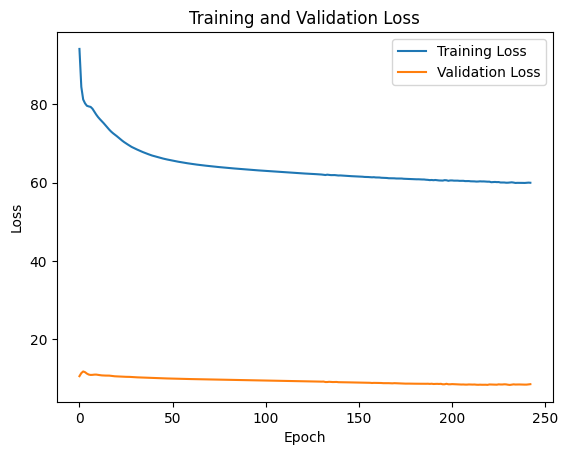

Model saved to models/gcn_1l_mutag.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.33%
Average Memory Usage: 0.15GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%

Total Training Time: 1.92s
Max CPU Usage: 36.65%
Max Memory Usage: 0.15GB
Max GPU Usage: 0.00GB
Max GPU Utilization: 0.00%


In [5]:
set_seed(42)
gcn1_mutag = GCN1Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn1_mutag)
print(f"Total number of trainable parameters: {(gcn1_mutag.count_parameters())*2}\n")
single_train(gcn1_mutag, mutag_train_loader, mutag_val_loader, lr=0.01, num_epochs=500, step_size=500, save_path='models/gcn_1l_mutag.pth')

In [6]:
single_test(gcn1_mutag, mutag_test_loader)

Accuracy: 0.8158
Average Sensitivity (Recall): 0.8462
Average Specificity: 0.7500


### GCN 2-Layer

GCN2Layer(
  (gcn1): GCN (7 -> 14)
  (gcn2): GCN (14 -> 28)
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 1180

Epoch 1, Train Loss: 86.46722114086151, Val Loss: 11.68528139591217
Time: 0.03s, CPU: 36.00%, Memory: 0.12GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 2, Train Loss: 80.8584617972374, Val Loss: 11.765201389789581
Time: 0.01s, CPU: 52.25%, Memory: 0.13GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 3, Train Loss: 79.94231444597244, Val Loss: 11.294539868831635
Time: 0.01s, CPU: 16.65%, Memory: 0.13GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 4, Train Loss: 79.69838201999664, Val Loss: 10.979202389717102
Time: 0.01s, CPU: 7.15%, Memory: 0.13GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 5, Train Loss: 78.92960119247437, Val Loss: 10.866539776325226
Time: 0.01s, CPU: 0.00%, Memory: 0.13GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 6, Train Loss: 77.34770423173904, Val Loss: 10.953080356121063
Time: 0.01s, CPU: 0.00%, Memory: 0.13GB, GPU: 0.00GB, GPU Util: 0.00%
E

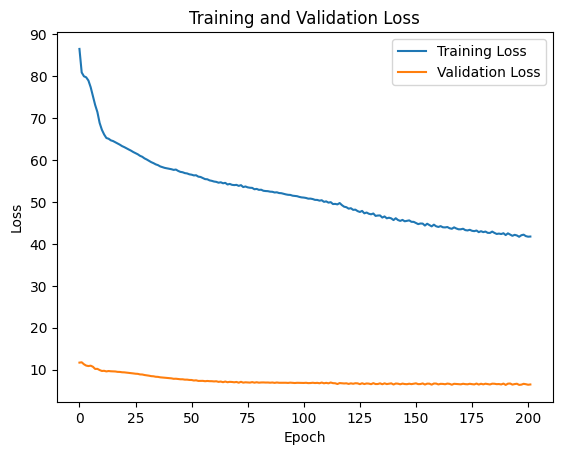

Model saved to models/gcn_2l_mutag.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.88%
Average Memory Usage: 0.14GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%

Total Training Time: 1.83s
Max CPU Usage: 52.25%
Max Memory Usage: 0.15GB
Max GPU Usage: 0.00GB
Max GPU Utilization: 0.00%


In [7]:
set_seed(42)
gcn2_mutag = GCN2Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn2_mutag)
print(f"Total number of trainable parameters: {(gcn2_mutag.count_parameters())*2}\n")
single_train(gcn2_mutag, mutag_train_loader, mutag_val_loader, lr=0.01, num_epochs=500, step_size=500, save_path='models/gcn_2l_mutag.pth')

In [8]:
single_test(gcn2_mutag, mutag_test_loader)

Accuracy: 0.9211
Average Sensitivity (Recall): 0.8846
Average Specificity: 1.0000


## GCESN

### GCESN 1-Layer

In [57]:
gcesn_mutag = GCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=6)
print(gcesn_mutag)
print(f"Total number of trainable parameters: {gcesn_mutag.count_parameters()}\n")

multi_train_test(gcesn_mutag, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=50, binary_classification=True)


GCESN_1layer(
  (ridge_layer): RidgeLayer(
    (linear): Linear(in_features=14, out_features=14, bias=True)
  )
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 240


Run 1/50 -> Loss: 44.21705, Total Training Time: 0.71s
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167

Run 2/50 -> Loss: 113.18212, Total Training Time: 0.27s
  Accuracy: 0.7895, Sensitivity: 0.9231, Specificity: 0.5000

Run 3/50 -> Loss: 56.12541, Total Training Time: 3.13s
  Accuracy: 0.8158, Sensitivity: 0.8846, Specificity: 0.6667

Run 4/50 -> Loss: 55.84995, Total Training Time: 0.68s
  Accuracy: 0.7895, Sensitivity: 0.9615, Specificity: 0.4167

Run 5/50 -> Loss: 52.59511, Total Training Time: 2.96s
  Accuracy: 0.7895, Sensitivity: 0.8846, Specificity: 0.5833

Run 6/50 -> Loss: 51.19816, Total Training Time: 3.49s
  Accuracy: 0.8421, Sensitivity: 0.9231, Specificity: 0.6667

Run 7/50 -> Loss: 53.39885, Total Training Time: 0.16s
  Accuracy: 0.7895, Sensit

### GCESN 2-Layer

In [58]:
gcesn_mutag_2 = GCESN_2layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_mutag_2)
print(f"Total number of trainable parameters: {gcesn_mutag_2.count_parameters()}\n")

multi_train_test(gcesn_mutag_2, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=50, binary_classification=True)

GCESN_2layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=14, out_features=28, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=28, out_features=14, bias=True)
  )
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 856


Run 1/50 -> Loss: 42.21466, Total Training Time: 3.55s
  Accuracy: 0.8947, Sensitivity: 0.9231, Specificity: 0.8333

Run 2/50 -> Loss: 44.74241, Total Training Time: 3.89s
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167

Run 3/50 -> Loss: 35.83250, Total Training Time: 3.37s
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167

Run 4/50 -> Loss: 39.63451, Total Training Time: 2.89s
  Accuracy: 0.9211, Sensitivity: 0.8846, Specificity: 1.0000

Run 5/50 -> Loss: 42.56508, Total Training Time: 0.64s
  Accuracy: 0.9474, Sensitivity: 0.9231, Specificity: 1.0000

Run 6/50 -> Loss: 48.36156, Total Training Time: 0.22s
  Accuracy: 0.9211, Sensitivity: 0.8846, S

## Decoupled GCESN

### 1-Layer

In [33]:
decoupled_gcesn_mutag = decoupledGCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=2)
print(decoupled_gcesn_mutag)
print(f"Total number of trainable parameters: {decoupled_gcesn_mutag.count_parameters()}\n")

multi_train_test(decoupled_gcesn_mutag, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=50, binary_classification=True)

decoupledGCESN_1layer(
  (gcn1): GCN (7 -> 14)
  (ridge_layer): RidgeLayer(
    (linear): Linear(in_features=14, out_features=14, bias=True)
  )
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 352


Run 1/50 -> Loss: 48.30139, Total Training Time: 2.72s
  Accuracy: 0.8947, Sensitivity: 0.9231, Specificity: 0.8333

Run 2/50 -> Loss: 53.02974, Total Training Time: 3.27s
  Accuracy: 0.7895, Sensitivity: 0.8846, Specificity: 0.5833

Run 3/50 -> Loss: 40.13105, Total Training Time: 3.19s
  Accuracy: 0.9474, Sensitivity: 0.9231, Specificity: 1.0000

Run 4/50 -> Loss: 48.19694, Total Training Time: 3.17s
  Accuracy: 0.8947, Sensitivity: 0.9615, Specificity: 0.7500

Run 5/50 -> Loss: 67.84303, Total Training Time: 3.11s
  Accuracy: 0.8158, Sensitivity: 0.9615, Specificity: 0.5000

Run 6/50 -> Loss: 58.01248, Total Training Time: 0.62s
  Accuracy: 0.8684, Sensitivity: 0.9231, Specificity: 0.7500

Run 7/50 -> Loss: 64.97096, Total Training Time: 

### 2-Layer

In [86]:
decoupled_gcesn_mutag_2 = decoupledGCESN_2layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=2)
print(decoupled_gcesn_mutag_2)
print(f"Total number of trainable parameters: {decoupled_gcesn_mutag_2.count_parameters()}\n")

multi_train_test(decoupled_gcesn_mutag_2, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=50, binary_classification=True)

decoupledGCESN_2layer(
  (gcn1): GCN (7 -> 14)
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=14, out_features=28, bias=True)
  )
  (gcn2): GCN (14 -> 28)
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 1010


Run 1/50 -> Loss: 46.30991, Total Training Time: 3.92s
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167

Run 2/50 -> Loss: 39.94903, Total Training Time: 3.66s
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167

Run 3/50 -> Loss: 40.64591, Total Training Time: 0.25s
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167

Run 4/50 -> Loss: 40.00577, Total Training Time: 0.27s
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167

Run 5/50 -> Loss: 39.61331, Total Training Time: 0.21s
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167

Run 6/50 -> Loss: 38.92535, Total Training Time: 0.28s
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167

Run 7/50 -> Loss: 38.

# Sandbox

In [98]:
class TrainableGCESN(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5, ridge_alpha=0.9):
        super(TrainableGCESN, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1)
        self.W = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.adjust_spectral_radius()
        
        self.fc = nn.Linear(self.hidden_features, num_classes)
    
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W.data *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h_new = F.relu(torch.mm(adj, torch.mm(h, self.W)))
            h = (1 - self.leaky_rate) * h + self.leaky_rate * h_new
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Custom optimizer hook to adjust spectral radius after each update
class SpectralRadiusOptimizerHook:
    def __init__(self, model):
        self.model = model

    def __call__(self):
        self.model.adjust_spectral_radius()

In [119]:
set_seed(42)
model = TrainableGCESN(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=6)
print(f'Total trainable parameters: {model.count_parameters()}')

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
spectral_hook = SpectralRadiusOptimizerHook(model)
for epoch in range(100):
    for data in mutag_train_loader:
        x, edge_index, batch, y = data.x.to(device), data.edge_index.to(device), data.batch.to(device), data.y.to(device)
        adj = utils.to_dense_adj(edge_index).squeeze(0).to(device)

        optimizer.zero_grad()
        output = model(x, adj, batch)
        
        # Ensure target tensor `y` matches the batch size of `output`
        loss = F.nll_loss(output, y)
        # loss = criterion(output, y)
        
        loss.backward()
        optimizer.step()
        spectral_hook()
        
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')



Total trainable parameters: 324
Epoch 1, Loss: 0.47106048464775085
Epoch 2, Loss: 0.4943133294582367
Epoch 3, Loss: 0.43529012799263
Epoch 4, Loss: 0.4312138557434082
Epoch 5, Loss: 0.6660427451133728
Epoch 6, Loss: 0.6354702711105347
Epoch 7, Loss: 0.21317103505134583
Epoch 8, Loss: 0.423541784286499
Epoch 9, Loss: 0.2784121334552765
Epoch 10, Loss: 0.2851869463920593
Epoch 11, Loss: 0.4774807393550873
Epoch 12, Loss: 0.51896733045578
Epoch 13, Loss: 0.5635321736335754
Epoch 14, Loss: 0.3366321623325348
Epoch 15, Loss: 0.7568030953407288
Epoch 16, Loss: 0.33130908012390137
Epoch 17, Loss: 0.3954927921295166
Epoch 18, Loss: 0.3759712874889374
Epoch 19, Loss: 0.414899617433548
Epoch 20, Loss: 0.44557079672813416
Epoch 21, Loss: 0.8758074045181274
Epoch 22, Loss: 0.5403642058372498
Epoch 23, Loss: 0.2616855204105377
Epoch 24, Loss: 0.44877901673316956
Epoch 25, Loss: 0.5747477412223816
Epoch 26, Loss: 0.44454026222229004
Epoch 27, Loss: 0.4778769612312317
Epoch 28, Loss: 0.55262434482574

In [120]:
single_test(model, mutag_test_loader)

Accuracy: 0.8684
Average Sensitivity (Recall): 0.9615
Average Specificity: 0.6667
